In [36]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [283]:
def display(img, cmap='gray'):
    fig = plt.figure(figsize = (7,7))
    plot = fig.add_subplot(111)
    plot.imshow(img, cmap=cmap)

In [284]:
#Now that we have the semantically segmented image, we can perform instance segmentation
#First, import the segmented image and the original full image

img = cv2.imread('images/segmented_image.png',0)
img_orig = cv2.imread('images/sem_particle_nano1.png',0)

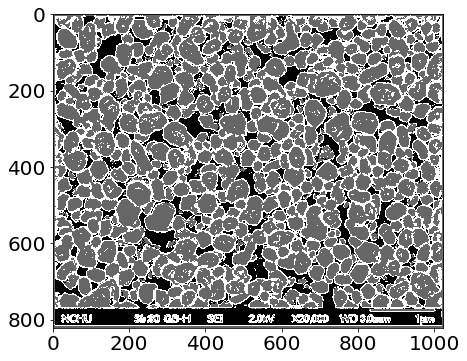

In [285]:
display(img)

In [287]:
# Check to make sure that the segmented image has only 3 unique color pixels

pd.Series(img.reshape(-1)).value_counts()

103    491261
255    224266
0      126201
dtype: int64

In [288]:
# Now we wish to convert the image to binary mode so it will work with the watershed algorithm
# This means the white pixel values around the edges of particles needs to be black (0) and the particles themselves need to be white (255)
img[img==255] = 0
img[img==103] = 255

In [289]:
pd.Series(img.reshape(-1)).value_counts()

255    491261
0      350467
dtype: int64

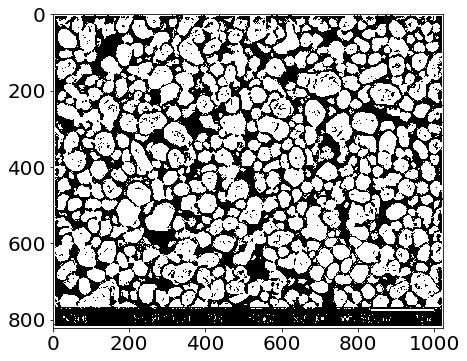

In [290]:
display(img)

In [291]:
# We can now performs advanced morphological transformation to erode some of the noise on particle edges
kernel = np.ones((3,3),np.uint8)
thres = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations = 2)

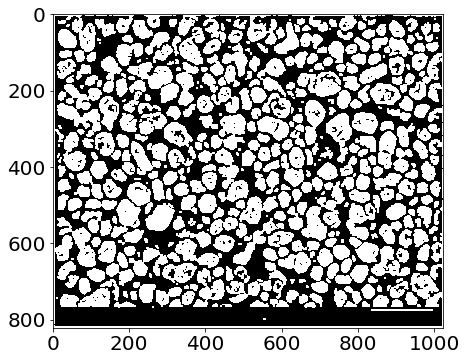

In [292]:
display(thres)

In [293]:
# Watershed Algorithm

In [248]:
from __future__ import print_function
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import argparse
import imutils
import cv2

In [298]:
img_orig_copy = img_orig.copy()
img_copy = img.copy()

In [299]:
# The first step to the watershed algorithm is to build a mask using "distance transform"
# which computes the exact Euclidean distance from every binary pixel to the nearest zero pixel, then find peaks in this distance map
d = ndimage.distance_transform_edt(thres)
localmax = peak_local_max(d, indices=False, min_distance=20, labels=thres)

# Perform a connected component analysis on the local peaks,
markers = ndimage.label(localmax, structure=np.ones((3, 3)))[0]

# The watershed algorithm is then applied after the mask and markers are built
labels = watershed(-d, markers, mask=thres)

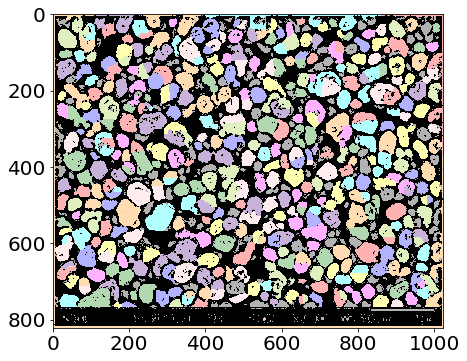

In [300]:
from skimage import measure, color, io
# Using the watershed labels, each instance segmented object can have its own color

img2 = color.label2rgb(labels, image = img_copy, alpha = 0.3, bg_label = 0, image_alpha = 1)
display(img2)

In [253]:
img_orig_copy = cv2.cvtColor(img_orig, cv2.COLOR_GRAY2RGB)

In [301]:
# loop over the unique labels returned by the watershed algorithm
found_particles = []

for label in np.unique(labels):
    
    # if the label is zero, we are examining the 'background' so simply ignore it
    if label == 0:
        continue
        
    # otherwise, we can create masks and find the contours
    mask = np.zeros(img_copy.shape, dtype="uint8")
    mask[labels == label] = 255
    
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    
    #Skip if false circles detected are too big or too small
    if r>50:
        continue
    if r<15:
        continue
    found_particles.append((x,y,r))

In [302]:
df = pd.DataFrame(np.round(found_particles,0), columns = ['x', 'y', 'r'])

In [303]:
# The list of x,y center coordinate along with radius of the enclosing circles
df

,x,y,r
0,572.0,30.0,20.0
1,125.0,27.0,19.0
2,938.0,28.0,18.0
3,494.0,26.0,16.0
4,900.0,39.0,25.0
...,...,...,...
350,43.0,753.0,26.0
351,901.0,761.0,16.0
352,322.0,762.0,18.0
353,386.0,760.0,20.0


In [269]:
# Knowing the x,y circle coordinates and radius, we can draw it on our original image
for i in df.values:
    cv2.circle(img_orig_copy, (int(i[0]), int(i[1])), int(i[2]), (0, 255, 0), 1)

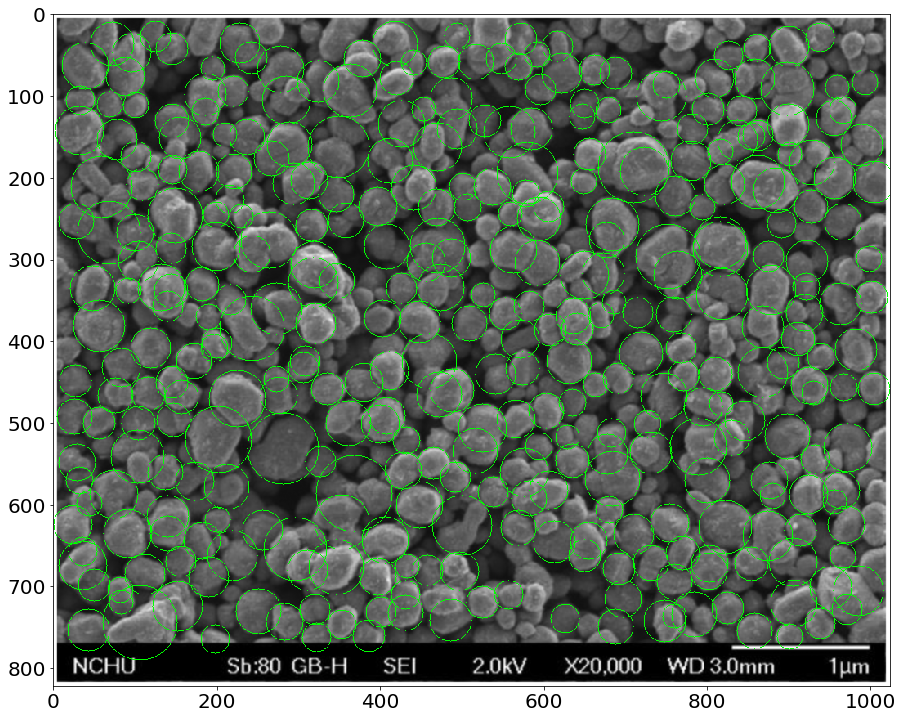

In [270]:
plt.figure(figsize = (15,15))
plt.imshow(img_orig_copy)

In [271]:
# To get real measurement values intead of pixels, we need to convert the number of pixels to micrometers using the scale bar
# 168.9 pixel per 1um (1000nm)
pixel_to_um = 168.9

In [274]:
# Now convert all radius values to diameters as nanometers
diameters_nm = [1000*df.values[i][2]*2/pixel_to_um for i in range(len(df))]

In [276]:
# Get descriptive statistics
np.round(pd.Series(diameters_nm).describe(),2)

count    819.00
mean     298.26
std       68.77
min      177.62
25%      248.67
50%      284.19
75%      331.56
max      556.54
dtype: float64

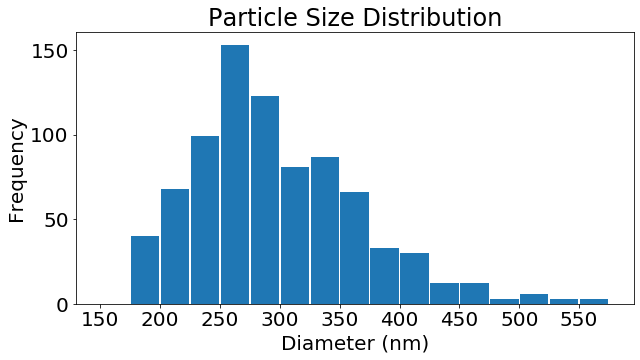

In [282]:
plt.figure(figsize =(10,5))
plt.hist(diameters_nm, bins = np.arange(150,600,25), rwidth = 0.95)
#plt.axvline(np.mean(diameters_nm), color = 'darkred')
plt.title('Particle Size Distribution')
plt.xlabel('Diameter (nm)')
plt.xticks(np.arange(150,600,50))
plt.ylabel('Frequency')
plt.rcParams.update({'font.size': 20})

In [646]:
plt.imsave('particle_detected.png', img_orig_copy, cmap='jet')